# Import packages and dataframe

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from Utils import AudioUtil
import pickle

from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, Dense, Flatten, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical

In [22]:
main_dir=os.getcwd()
train_dir=main_dir+'\\train'
print('{}\n{}'.format(main_dir,train_dir))

c:\Users\david\Desktop\LOOP_Q_PRIZE
c:\Users\david\Desktop\LOOP_Q_PRIZE\train


In [23]:
train_df = pd.read_csv(main_dir+'\\2022challengeA_train.csv', index_col=0)
display(train_df[train_df.isna().any(axis=1)])
train_df = train_df.dropna()
train_df = train_df.drop([168], axis = 0)
train_df.index=range(len(train_df))

n_samples = len(train_df)

print('Number of rows: {}'.format(train_df.shape[0]))
display(train_df.sample(10))


au = AudioUtil()

,file_id,emotion,origin
8937,b78b41bd-3c6f-4182-94ac-430bad71f4e0.wav,NaN,tess


Number of rows: 10109


,file_id,emotion,origin
3508,0d07bcf2-3774-4782-a9d8-d55ed1799f31.wav,neutral,crema
4090,077a62e2-16bb-46e1-8648-c1a03305bbe3.wav,disgust,crema
6052,ec6c5fe2-b78c-4060-b0d5-712f6557eaad.wav,sadness,crema
3074,dc78bd98-d216-49c9-9275-c40e1b2b8fad.wav,angry,crema
127,456cf78f-29a5-42d8-805e-3fa45ab9c28f.wav,happy,crema
3145,e6cfeda6-8c65-4b92-9109-152ee07dd016.wav,happy,crema
315,1269cb7c-ba71-4683-baeb-7f5397077aa5.wav,sadness,crema
371,682e1064-a0f2-4d69-a985-33aa9ab509ce.wav,disgust,crema
8378,0780486c-96bf-4f6f-a816-7f0e8f93357f.wav,disgust,tess
440,9218b432-525b-4daa-a8d3-9fe05c0a22ef.wav,happy,crema


# Creating mask for train val and test and label data


First of all I am going to create a three masks for the train, validation and test sets of relative dimension = (0.8, 0.1, 0.1) to reuse in any experiment.

In [8]:
# Creating Mask for train, val, test

n = np.arange(n_samples)
mask_train, mask_test = train_test_split(n, test_size = 0.2)
mask_val, mask_test = train_test_split(mask_test, test_size = 0.5)

np.save('mask_train', mask_train)
np.save('mask_val', mask_val)
np.save('mask_test', mask_test)

In [37]:
enc = OneHotEncoder()
y = enc.fit_transform(np.array(train_df['emotion']).reshape(-1,1)).toarray()
np.save('y', y)

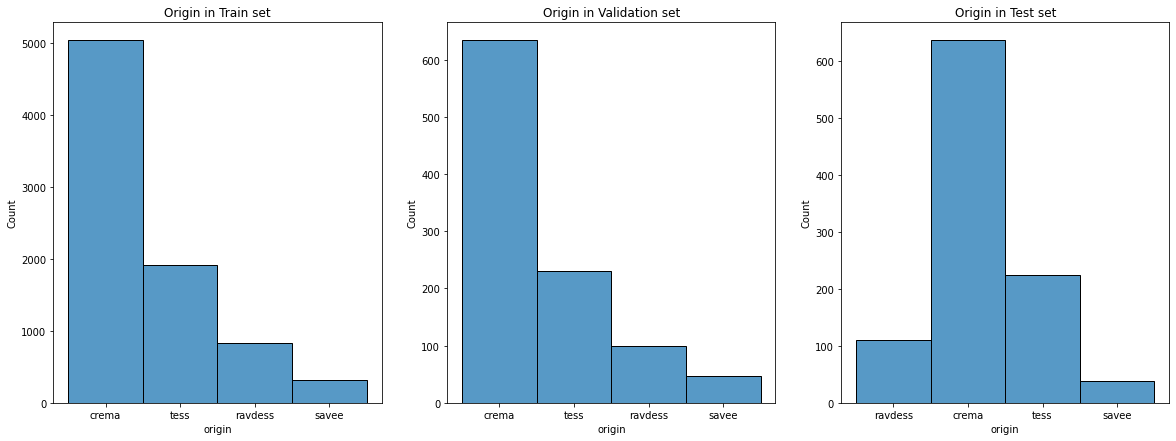

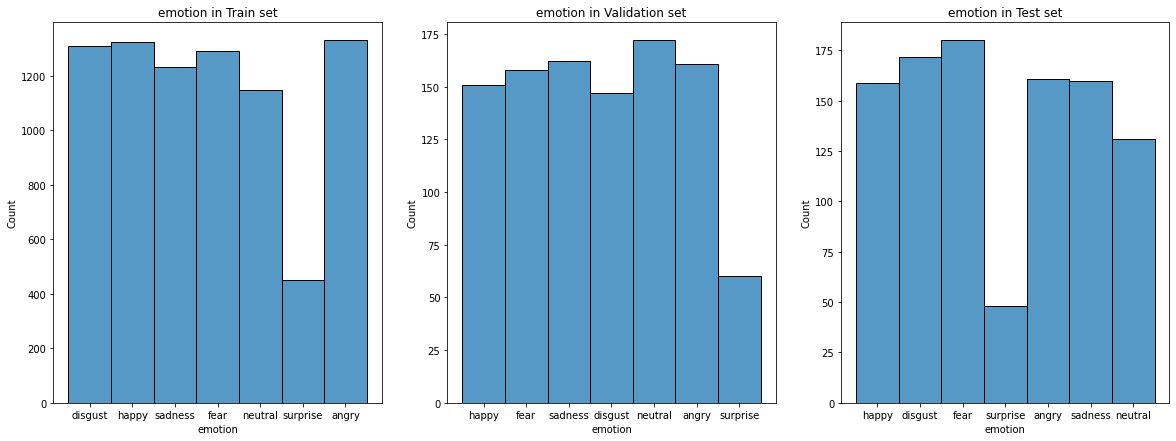

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (20,7))

sns.histplot(ax = axs[0], x = train_df['origin'][mask_train])
axs[0].set_title('Origin in Train set')
sns.histplot(ax = axs[1], x = train_df['origin'][mask_val])
axs[1].set_title('Origin in Validation set')
sns.histplot(ax = axs[2], x = train_df['origin'][mask_test])
axs[2].set_title('Origin in Test set')


plt.show()

fig, axs = plt.subplots(1, 3, figsize = (20,7))

sns.histplot(ax = axs[0], x = train_df['emotion'][mask_train])
axs[0].set_title('emotion in Train set')
sns.histplot(ax = axs[1], x = train_df['emotion'][mask_val])
axs[1].set_title('emotion in Validation set')
sns.histplot(ax = axs[2], x = train_df['emotion'][mask_test], )
axs[2].set_title('emotion in Test set')

plt.show()

Even without using a stratified split, the train, validation and test sets are equally distribuited among origin and emotion.

# Feature creation

In order to normalize the audio files I am going to resample all the audio to the minimum sampling rate (16000 Hz) and fix the duration of the audio at 4s.

If an audio is longer then 4s I simply trunc it, while when it is shorter I repeat the audio untill it reaches 4s of duration.

I have augmented the dataset by adding random noise and random time shifting.

Once the audio are normalized, I have extracted different features for different models:

- For the Multi-input model I have extracted: the Mel scale spectrogram, the mfccs, the chromagram, the tonnetz representation and the spectral contrast.

  I have used a length of the fft window of 1024, which corespond to 0.064s, and a number of samples between successive frames of 512. 
  In this way all the features have 126 time steps

  I have augmented the dataset by adding random noise and random time shifting. For each recording I have created two augmented copies so to have a final dataset three times bigger than the original.
- For the other models I have used only the mel scale spectrogram.

  I have used a length of the fft window of 512, that corresponds to 0.032s, and a number of samples between successive frames of 256.
   In this way the spectrograms have 251 time steps. 

  I have augmented the dataset by adding random noise and random time shifting. For each recording I have created one augmented copy so to have a final dataset two times bigger than the original.

## Multi-input Features

I am going to extract the features for the Multi-input model

In [24]:
# setting the parameters

n_fft = 1024
n_mels = 64
hop_len = int(n_fft / 2)

In [28]:
n = np.random.randint(0,n_samples)
file_audio = train_dir + '\\' + train_df.loc[n, 'file_id']
aud = au.open(file_audio)

# resample and padd the audio
aud = au.process_audio(aud)

# extracting the different features:

# mel scale spectrogram
mel_sg = au.spectro_gram(aud, n_mels = n_mels, n_fft = n_fft, hop_len = hop_len).transpose()
print('Shape of mel scale spectrogram: ', mel_sg.shape)

# mfcc
mfcc = librosa.feature.mfcc(y = aud[0], sr = aud[1]).transpose()
print('Shape of mfcc: ', mfcc.shape)

# chromagram
chroma_gram = librosa.feature.chroma_cqt(y = aud[0], sr = aud[1], hop_length=hop_len).transpose()
print('Shape of chroma gram: ', chroma_gram.shape)

# tonnetz representetion
tonnetz = librosa.feature.tonnetz(y = aud[0], sr = aud[1]).transpose()
print('Shape of tonnetz: ', tonnetz.shape)

# spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(y = aud[0], sr = aud[1], n_fft = n_fft, hop_length = hop_len).transpose()
print('Shape of spectral_contrast: ', spectral_contrast.shape)

Shape of mel scale spectrogram:  (126, 64)
Shape of mfcc:  (126, 20)
Shape of chroma gram:  (126, 12)
Shape of tonnetz:  (126, 6)
Shape of spectral_contrast:  (126, 7)


Displaying the features

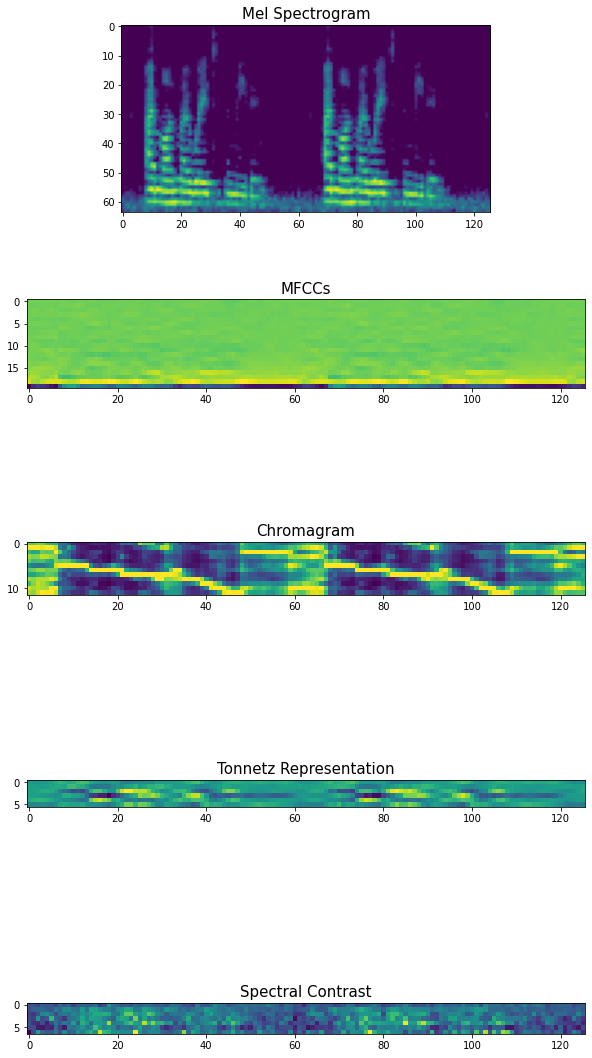

In [50]:
fig, axs = plt.subplots(5, figsize = (10,20))

axs[0].imshow(mel_sg.transpose()[::-1])
axs[0].set_title('Mel Spectrogram', size = 15)
axs[1].imshow(mfcc.transpose()[::-1])
axs[1].set_title('MFCCs', size = 15)
axs[2].imshow(chroma_gram.transpose()[::-1])
axs[2].set_title('Chromagram', size = 15)
axs[3].imshow(tonnetz.transpose()[::-1])
axs[3].set_title('Tonnetz Representation', size = 15)
axs[4].imshow(spectral_contrast.transpose()[::-1])
axs[4].set_title('Spectral Contrast', size = 15)
plt.savefig('features.png', facecolor = 'w')
plt.show()


Epoch 1/40
506/506 [==============================] - ETA: 0s - loss: 1.7050 - categorical_accuracy: 0.2839

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 401s 791ms/step - loss: 1.7050 - categorical_accuracy: 0.2839 - val_loss: 1.5028 - val_categorical_accuracy: 0.4120
Epoch 2/40
506/506 [==============================] - ETA: 0s - loss: 1.4376 - categorical_accuracy: 0.4254

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 401s 794ms/step - loss: 1.4376 - categorical_accuracy: 0.4254 - val_loss: 1.3808 - val_categorical_accuracy: 0.4792
Epoch 3/40
506/506 [==============================] - ETA: 0s - loss: 1.2562 - categorical_accuracy: 0.5076

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 411s 812ms/step - loss: 1.2562 - categorical_accuracy: 0.5076 - val_loss: 1.2844 - val_categorical_accuracy: 0.4847
Epoch 4/40
506/506 [==============================] - ETA: 0s - loss: 1.1948 - categorical_accuracy: 0.5373

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 420s 831ms/step - loss: 1.1948 - categorical_accuracy: 0.5373 - val_loss: 1.1791 - val_categorical_accuracy: 0.5504
Epoch 5/40
506/506 [==============================] - 412s 814ms/step - loss: 1.1445 - categorical_accuracy: 0.5506 - val_loss: 1.1578 - val_categorical_accuracy: 0.5485
Epoch 6/40
506/506 [==============================] - 413s 817ms/step - loss: 1.1234 - categorical_accuracy: 0.5591 - val_loss: 1.1601 - val_categorical_accuracy: 0.5485
Epoch 7/40
506/506 [==============================] - ETA: 0s - loss: 1.0894 - categorical_accuracy: 0.5762

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 417s 824ms/step - loss: 1.0894 - categorical_accuracy: 0.5762 - val_loss: 1.1394 - val_categorical_accuracy: 0.5663
Epoch 8/40
506/506 [==============================] - 422s 834ms/step - loss: 1.0725 - categorical_accuracy: 0.5775 - val_loss: 1.1651 - val_categorical_accuracy: 0.5396
Epoch 9/40
506/506 [==============================] - 419s 828ms/step - loss: 1.0541 - categorical_accuracy: 0.5911 - val_loss: 1.1486 - val_categorical_accuracy: 0.5549
Epoch 10/40
506/506 [==============================] - ETA: 0s - loss: 1.0313 - categorical_accuracy: 0.5999

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 418s 826ms/step - loss: 1.0313 - categorical_accuracy: 0.5999 - val_loss: 1.1151 - val_categorical_accuracy: 0.5811
Epoch 11/40
506/506 [==============================] - 412s 814ms/step - loss: 1.0250 - categorical_accuracy: 0.6016 - val_loss: 1.1371 - val_categorical_accuracy: 0.5554
Epoch 12/40
506/506 [==============================] - 416s 822ms/step - loss: 1.0026 - categorical_accuracy: 0.6112 - val_loss: 1.1352 - val_categorical_accuracy: 0.5589
Epoch 13/40
506/506 [==============================] - 421s 832ms/step - loss: 0.9934 - categorical_accuracy: 0.6154 - val_loss: 1.0894 - val_categorical_accuracy: 0.5781
Epoch 14/40
506/506 [==============================] - 410s 811ms/step - loss: 0.9698 - categorical_accuracy: 0.6219 - val_loss: 1.1175 - val_categorical_accuracy: 0.5603
Epoch 15/40
506/506 [==============================] - 408s 807ms/step - loss: 0.9794 - categorical_accuracy: 0.6196 - val_loss: 1.1403 - val_categorical_acc

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 409s 809ms/step - loss: 0.9216 - categorical_accuracy: 0.6452 - val_loss: 1.1065 - val_categorical_accuracy: 0.5846
Epoch 21/40
506/506 [==============================] - 406s 803ms/step - loss: 0.8988 - categorical_accuracy: 0.6489 - val_loss: 1.1385 - val_categorical_accuracy: 0.5529
Epoch 22/40
506/506 [==============================] - 408s 806ms/step - loss: 0.9015 - categorical_accuracy: 0.6553 - val_loss: 1.1227 - val_categorical_accuracy: 0.5757
Epoch 23/40
506/506 [==============================] - ETA: 0s - loss: 0.8928 - categorical_accuracy: 0.6538

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 416s 822ms/step - loss: 0.8928 - categorical_accuracy: 0.6538 - val_loss: 1.1319 - val_categorical_accuracy: 0.5910
Epoch 24/40
506/506 [==============================] - 413s 817ms/step - loss: 0.8769 - categorical_accuracy: 0.6608 - val_loss: 1.1711 - val_categorical_accuracy: 0.5747
Epoch 25/40
506/506 [==============================] - 413s 817ms/step - loss: 0.8670 - categorical_accuracy: 0.6627 - val_loss: 1.1781 - val_categorical_accuracy: 0.5816
Epoch 26/40
506/506 [==============================] - 408s 807ms/step - loss: 0.8715 - categorical_accuracy: 0.6588 - val_loss: 1.1887 - val_categorical_accuracy: 0.5504
Epoch 27/40
506/506 [==============================] - 405s 801ms/step - loss: 0.8509 - categorical_accuracy: 0.6724 - val_loss: 1.1640 - val_categorical_accuracy: 0.5732
Epoch 28/40
506/506 [==============================] - 406s 802ms/step - loss: 0.8570 - categorical_accuracy: 0.6713 - val_loss: 1.1237 - val_categorical_acc

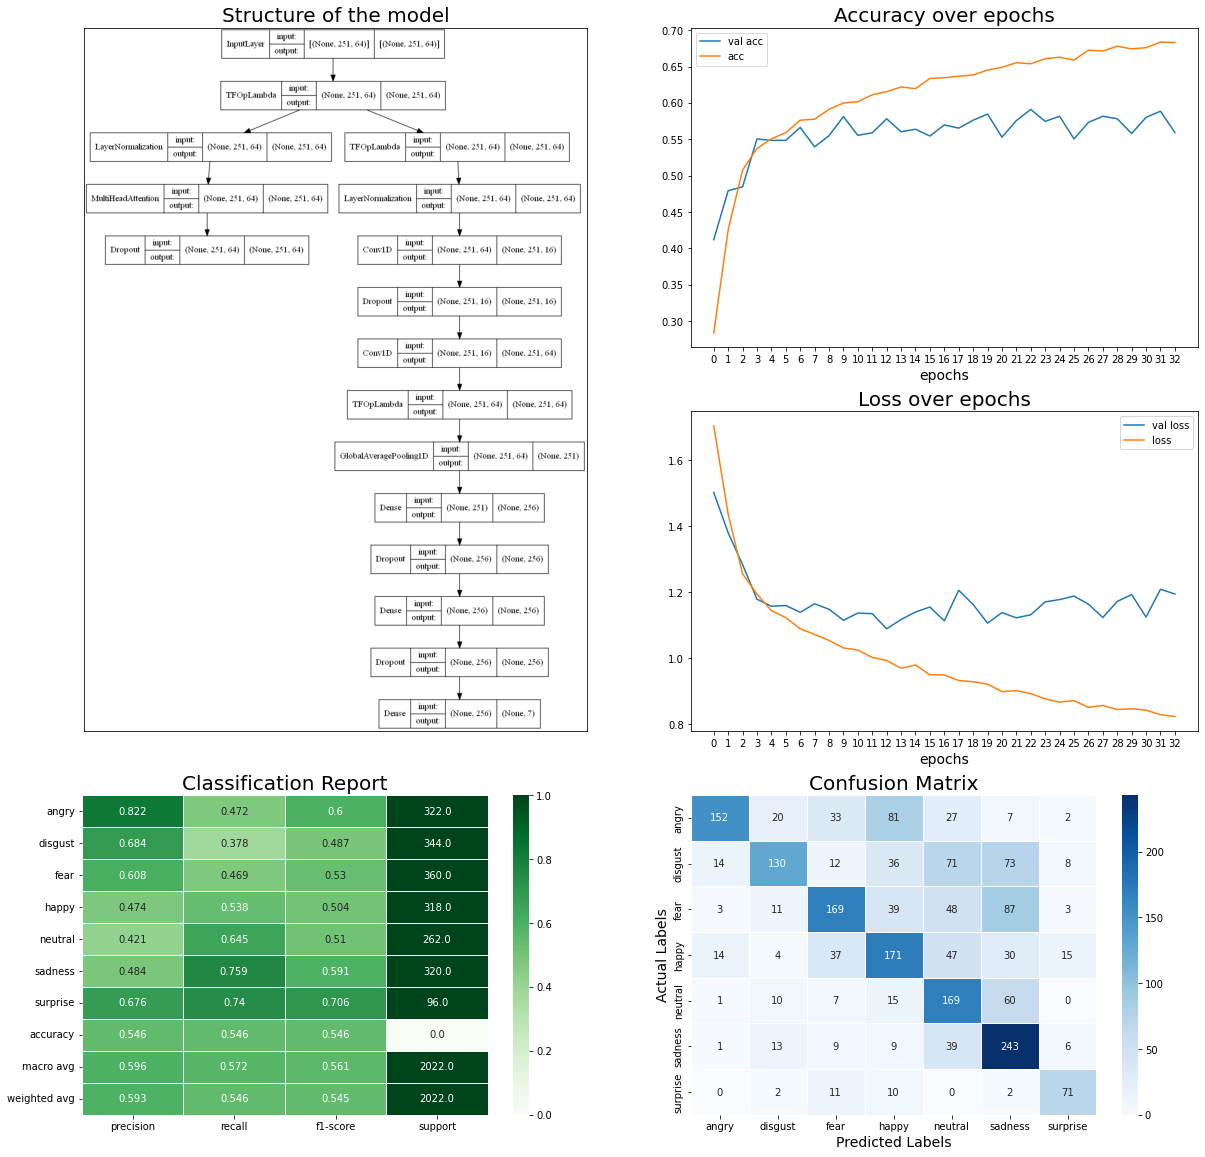

In [ ]:
compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 'models/very_big/small_trasformer_sg', 'report/very_big/small_trasformer_sg.png')

Epoch 1/40
506/506 [==============================] - ETA: 0s - loss: 1.7050 - categorical_accuracy: 0.2839

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 401s 791ms/step - loss: 1.7050 - categorical_accuracy: 0.2839 - val_loss: 1.5028 - val_categorical_accuracy: 0.4120
Epoch 2/40
506/506 [==============================] - ETA: 0s - loss: 1.4376 - categorical_accuracy: 0.4254

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 401s 794ms/step - loss: 1.4376 - categorical_accuracy: 0.4254 - val_loss: 1.3808 - val_categorical_accuracy: 0.4792
Epoch 3/40
506/506 [==============================] - ETA: 0s - loss: 1.2562 - categorical_accuracy: 0.5076

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 411s 812ms/step - loss: 1.2562 - categorical_accuracy: 0.5076 - val_loss: 1.2844 - val_categorical_accuracy: 0.4847
Epoch 4/40
506/506 [==============================] - ETA: 0s - loss: 1.1948 - categorical_accuracy: 0.5373

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 420s 831ms/step - loss: 1.1948 - categorical_accuracy: 0.5373 - val_loss: 1.1791 - val_categorical_accuracy: 0.5504
Epoch 5/40
506/506 [==============================] - 412s 814ms/step - loss: 1.1445 - categorical_accuracy: 0.5506 - val_loss: 1.1578 - val_categorical_accuracy: 0.5485
Epoch 6/40
506/506 [==============================] - 413s 817ms/step - loss: 1.1234 - categorical_accuracy: 0.5591 - val_loss: 1.1601 - val_categorical_accuracy: 0.5485
Epoch 7/40
506/506 [==============================] - ETA: 0s - loss: 1.0894 - categorical_accuracy: 0.5762

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 417s 824ms/step - loss: 1.0894 - categorical_accuracy: 0.5762 - val_loss: 1.1394 - val_categorical_accuracy: 0.5663
Epoch 8/40
506/506 [==============================] - 422s 834ms/step - loss: 1.0725 - categorical_accuracy: 0.5775 - val_loss: 1.1651 - val_categorical_accuracy: 0.5396
Epoch 9/40
506/506 [==============================] - 419s 828ms/step - loss: 1.0541 - categorical_accuracy: 0.5911 - val_loss: 1.1486 - val_categorical_accuracy: 0.5549
Epoch 10/40
506/506 [==============================] - ETA: 0s - loss: 1.0313 - categorical_accuracy: 0.5999

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 418s 826ms/step - loss: 1.0313 - categorical_accuracy: 0.5999 - val_loss: 1.1151 - val_categorical_accuracy: 0.5811
Epoch 11/40
506/506 [==============================] - 412s 814ms/step - loss: 1.0250 - categorical_accuracy: 0.6016 - val_loss: 1.1371 - val_categorical_accuracy: 0.5554
Epoch 12/40
506/506 [==============================] - 416s 822ms/step - loss: 1.0026 - categorical_accuracy: 0.6112 - val_loss: 1.1352 - val_categorical_accuracy: 0.5589
Epoch 13/40
506/506 [==============================] - 421s 832ms/step - loss: 0.9934 - categorical_accuracy: 0.6154 - val_loss: 1.0894 - val_categorical_accuracy: 0.5781
Epoch 14/40
506/506 [==============================] - 410s 811ms/step - loss: 0.9698 - categorical_accuracy: 0.6219 - val_loss: 1.1175 - val_categorical_accuracy: 0.5603
Epoch 15/40
506/506 [==============================] - 408s 807ms/step - loss: 0.9794 - categorical_accuracy: 0.6196 - val_loss: 1.1403 - val_categorical_acc

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 409s 809ms/step - loss: 0.9216 - categorical_accuracy: 0.6452 - val_loss: 1.1065 - val_categorical_accuracy: 0.5846
Epoch 21/40
506/506 [==============================] - 406s 803ms/step - loss: 0.8988 - categorical_accuracy: 0.6489 - val_loss: 1.1385 - val_categorical_accuracy: 0.5529
Epoch 22/40
506/506 [==============================] - 408s 806ms/step - loss: 0.9015 - categorical_accuracy: 0.6553 - val_loss: 1.1227 - val_categorical_accuracy: 0.5757
Epoch 23/40
506/506 [==============================] - ETA: 0s - loss: 0.8928 - categorical_accuracy: 0.6538

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 416s 822ms/step - loss: 0.8928 - categorical_accuracy: 0.6538 - val_loss: 1.1319 - val_categorical_accuracy: 0.5910
Epoch 24/40
506/506 [==============================] - 413s 817ms/step - loss: 0.8769 - categorical_accuracy: 0.6608 - val_loss: 1.1711 - val_categorical_accuracy: 0.5747
Epoch 25/40
506/506 [==============================] - 413s 817ms/step - loss: 0.8670 - categorical_accuracy: 0.6627 - val_loss: 1.1781 - val_categorical_accuracy: 0.5816
Epoch 26/40
506/506 [==============================] - 408s 807ms/step - loss: 0.8715 - categorical_accuracy: 0.6588 - val_loss: 1.1887 - val_categorical_accuracy: 0.5504
Epoch 27/40
506/506 [==============================] - 405s 801ms/step - loss: 0.8509 - categorical_accuracy: 0.6724 - val_loss: 1.1640 - val_categorical_accuracy: 0.5732
Epoch 28/40
506/506 [==============================] - 406s 802ms/step - loss: 0.8570 - categorical_accuracy: 0.6713 - val_loss: 1.1237 - val_categorical_acc

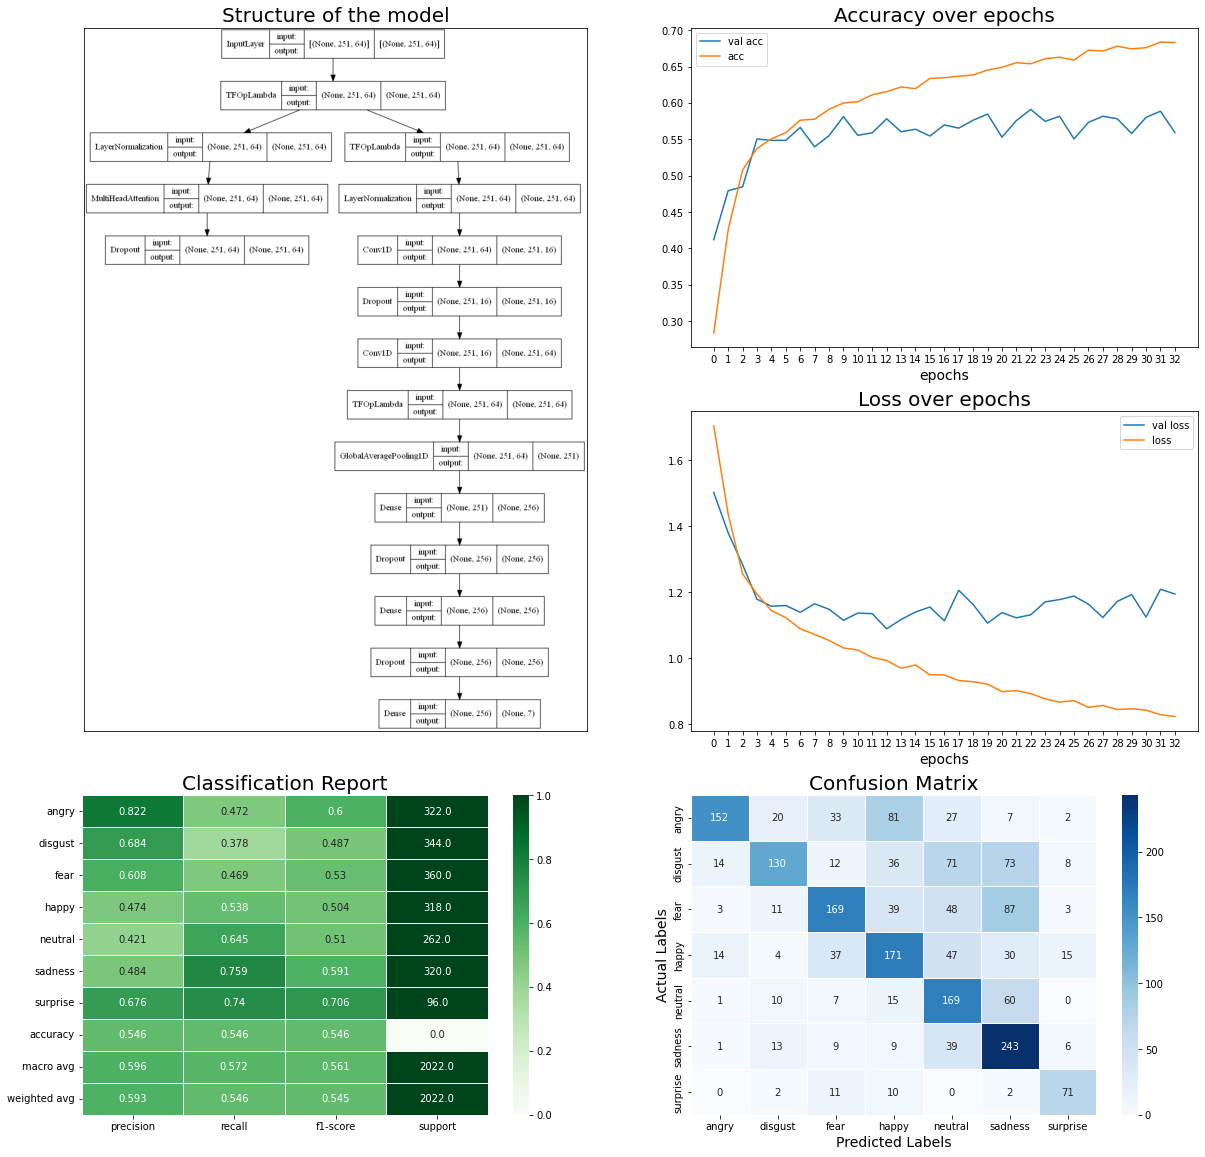

In [ ]:
compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 'models/very_big/small_trasformer_sg', 'report/very_big/small_trasformer_sg.png')

inizializing the arrays of the features

In [13]:
# Mel Spectrogram
sg = np.zeros(shape = (n_samples*3, 126, 64))
# MFCCs
mf = np.zeros(shape = (n_samples*3, 126, 20))
# Chroma gram
cg = np.zeros(shape = (n_samples*3, 126, 12))
# Tonetz Representation
tn = np.zeros(shape = (n_samples*3, 126, 6))
# Spectral contrast
sc = np.zeros(shape = (n_samples*3, 126, 7))

Creating the features

In [14]:
print('Creating the dataset with the features ...')

for i in range(n_samples):
    audio_file = train_dir + '\\' + train_df.loc[i, 'file_id']
    aud = librosa.load(audio_file)
    aud = au.process_audio(aud)
    for j in range(3):

        # Data Augmentation
        if j in [1,2]:
            aud = au.noise(aud)
            aud = au.time_shift(aud)

        mel_sg = au.spectro_gram(aud, n_mels = n_mels, n_fft = n_fft, hop_len = hop_len)
        mfcc = librosa.feature.mfcc(S = mel_sg)
        chroma_gram = librosa.feature.chroma_cqt(y = aud[0], sr = aud[1], hop_length=hop_len)
        tonnetz = librosa.feature.tonnetz(chroma = chroma_gram)
        spectral_contrast = librosa.feature.spectral_contrast(y = aud[0], sr = aud[1], n_fft = n_fft, hop_length = hop_len)

        k = n_samples*j + i

        sg[k] = mel_sg.transpose()
        mf[k] = mfcc.transpose()
        cg[k] = chroma_gram.transpose()
        tn[k] = tonnetz.transpose()
        sc[k] = spectral_contrast.transpose() 

    if i%100==0:
        print (str(['=' for i in range(i//100)]+['>']+['.' for i in range(n_samples//100-i//100)]).replace(',','').replace(' ','').replace("'", ''), end='\r')
print()       

print('Done !!')

Creating the dataset with the features ...
[=====================================================================================================>]
Done !!


"\n\nprint('Normalizing the features ...')\n\nsg = normalize(sg)\nmf = normalize(mf)\ncg = normalize(cg)\ntn = normalize(tn)\nsc = normalize(sc)\n\nprint('Done !')\n"

Saving the features

In [36]:
np.save('multi_input_features/sg.npy', sg)
np.save('multi_input_features/mf.npy', mf)
np.save('multi_input_features/cg.npy', cg)
np.save('multi_input_features/tn.npy', tn)
np.save('multi_input_features/sc.npy', sc)

## Other model's features

In [9]:
n_fft = 512
n_mels = 64
hop_len = int(n_fft / 2)

Looking at the shape

In [10]:
n = np.random.randint(0,n_samples)
file_audio = train_dir + '\\' + train_df.loc[n, 'file_id']
aud = au.open(file_audio)

# resample and padd the audio
aud = au.process_audio(aud)

# mel scale spectrogram
mel_sg = au.spectro_gram(aud, n_mels = n_mels, n_fft = n_fft, hop_len = hop_len).transpose()
print('Shape of mel scale spectrogram: ', mel_sg.shape)

Shape of mel scale spectrogram:  (251, 64)


In [16]:
# inizializing the arrays of the features

sg = np.zeros(shape = (n_samples*2, 251, 64))

In [40]:
print('Creating the dataset with the features ...')

sg = np.zeros(shape = (n_samples*2, 251, 64))

for i in range(n_samples):
    audio_file = train_dir + '\\' + train_df.loc[i, 'file_id']
    aud = librosa.load(audio_file)
    aud = au.process_audio(aud)
    for j in range(2):

        # Data Augmentation
        if j == 1:
            aud = au.noise(aud)
            aud = au.time_shift(aud)

        mel_sg = au.spectro_gram(aud, n_mels = n_mels, n_fft = n_fft, hop_len = hop_len)
        
        k = n_samples*j + i

        sg[k] = mel_sg.transpose()

    if i%100==0:
        print (str(['=' for i in range(i//100)]+['>']+['.' for i in range(n_samples//100-i//100)]).replace(',','').replace(' ','').replace("'", ''), end='\r')
print()       

print('Done !!')

Creating the dataset with the features ...
[=====================================================================================================>]
Done !!


In [42]:
np.save('others_model_features/sg', sg)

In [ ]:
df = train_df.sample(100)

for i in range(len(train_df)):
    file_audio = train_dir + '\\' + df['file_id'].iloc[i]
    aud = librosa.load(file_audio)
    aud = au.resample(aud, 16000)
    samples, sr = aud
    